In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, functions as F, types as T
import seaborn as sns
from matplotlib.ticker import MaxNLocator

## Определение путей к данным

- Формируется словарь paths, содержащий пути к файлам в формате Parquet:

  - `metadata` → метаданные с применёнными UDF: `with_udf.parquet`

  - `query1` → результаты первого запроса (топ пациентов): `query1_top_patients.parquet`

  - `query2` → результаты второго запроса (join представлений): `query2_view_lookup_join.parquet`

  - `query3` → результаты третьего запроса (статистика по COVID): `query3_covid_stats.parquet`

  - `kmeans` → результаты кластеризации KMeans: `kmeans_clusters.parquet`

In [41]:
BASE_PATH = "hdfs://hadoop-namenode:9000/user/hadoop/covid_dataset/processed"

paths = {
    "metadata": f"{BASE_PATH}/with_udf.parquet",
    "query1": f"{BASE_PATH}/query1_top_patients.parquet",
    "query2": f"{BASE_PATH}/query2_view_lookup_join.parquet",
    "query3": f"{BASE_PATH}/query3_covid_stats.parquet",
    "kmeans": f"{BASE_PATH}/kmeans_clusters.parquet",
}

In [42]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("Covid_Hive_HDFS") \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("spark.sql.warehouse.dir", "hdfs://hadoop-namenode:9000/user/hive/warehouse") \
    .config("spark.local.dir", "/tmp/spark") \
    .config("spark.sql.hive.metastore.version", "4.0.1") \
    .config("spark.sql.hive.metastore.jars", "/opt/hive/lib/*") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

## Загрузка данных из файлов Parquet

- Загружаются данные в DataFrame с помощью `pandas.read_parquet`:

  - `metadata` ← данные из `metadata_with_udf.parquet`

  - `query1` ← данные из `query1_top_patients.parquet`

  - `query2` ← данные из `query2_views_join.parquet`

  - `query3` ← данные из `query3_covid_stats.parquet`

  - `kmeans` ← данные из `kmeans_clusters.parquet`

- После загрузки выводится сообщение:


In [43]:
metadata = spark.read.parquet(paths["metadata"]).toPandas()
query1 = spark.read.parquet(paths["query1"]).toPandas()
query2 = spark.read.parquet(paths["query2"]).toPandas()
query3 = spark.read.parquet(paths["query3"]).toPandas()
kmeans = spark.read.parquet(paths["kmeans"]).toPandas()

## Визуализация распределения возраста пациентов

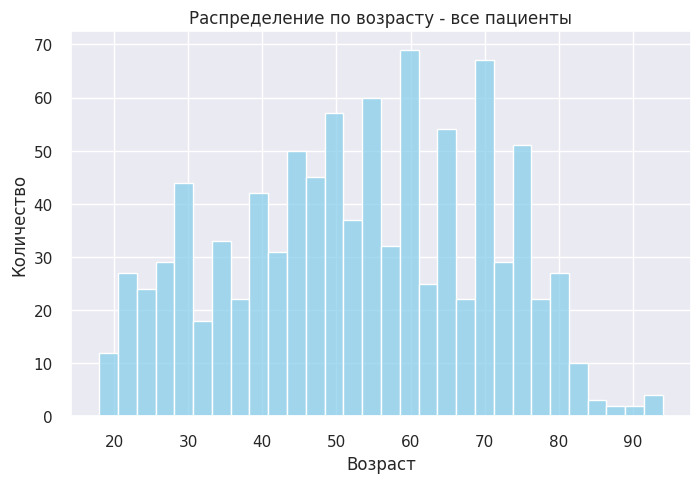

In [44]:
column_age =  metadata["age"].astype(float).astype(int)
column_age = column_age.sort_values()
plt.figure(figsize=(8,5))
sns.histplot(column_age, bins=30, color="skyblue")
plt.title("Распределение по возрасту - все пациенты")
plt.xlabel("Возраст")
plt.ylabel("Количество")

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # максимум 6 тиков по X

plt.show()

## Круговая диаграмма распределения диагнозов


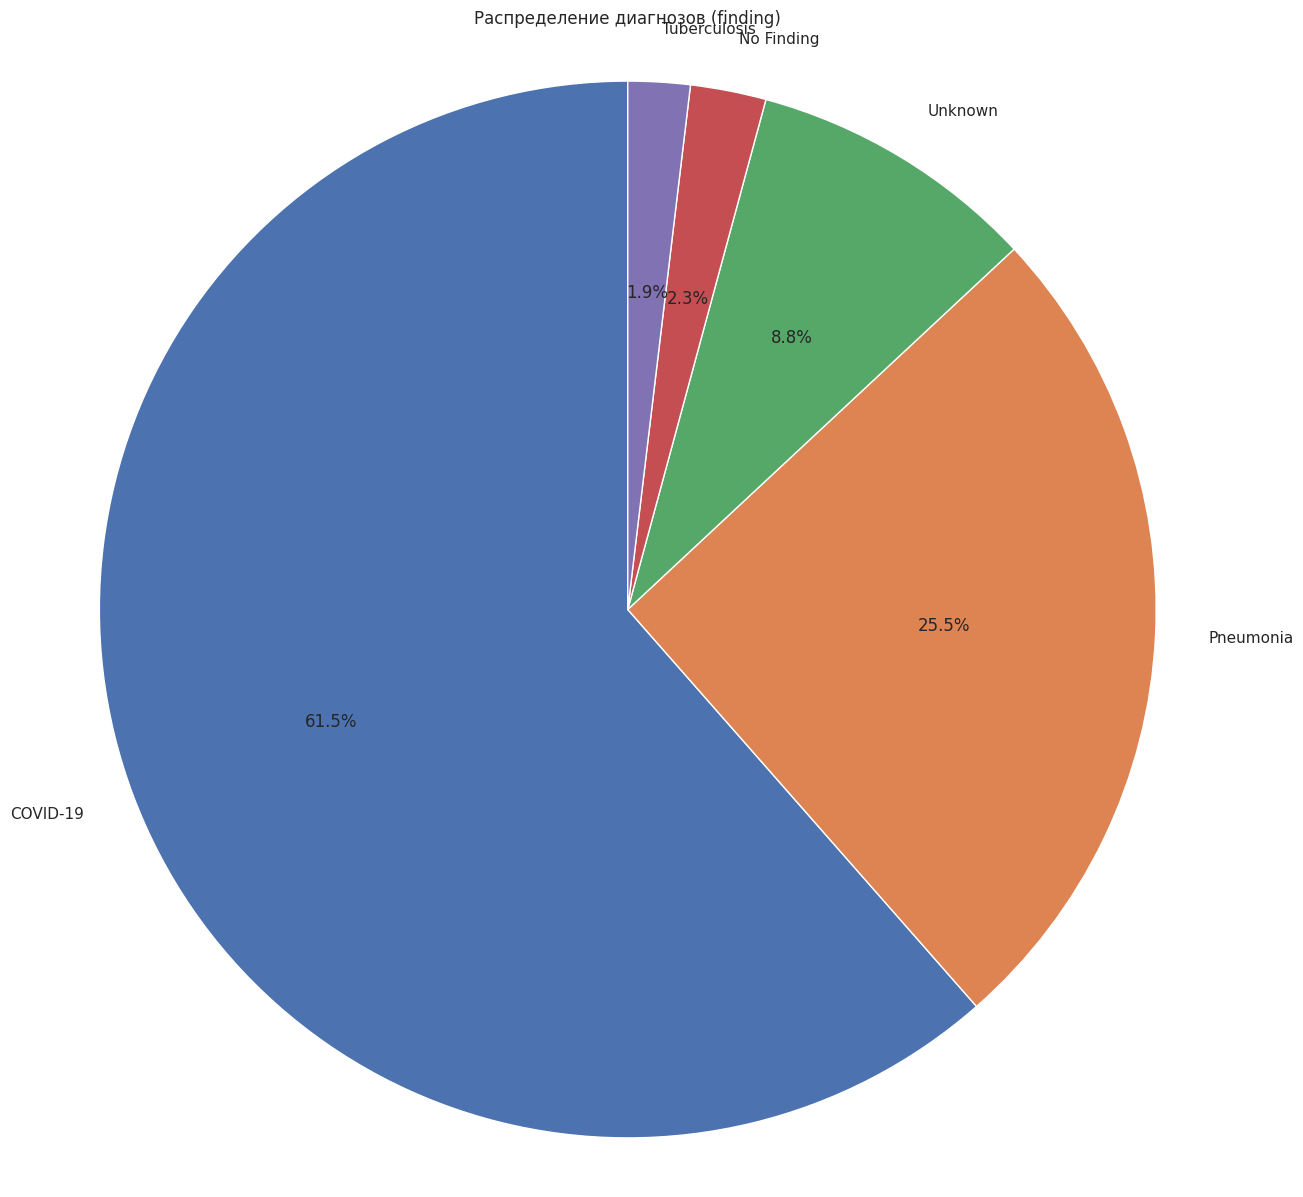

In [45]:
# Подсчёт количества значений в колонке
counts = metadata["finding"].value_counts()

# Данные для подписей и долей
labels = counts.index
sizes = counts.values

# Строим круговую диаграмму с дыркой (donut chart)
fig, ax = plt.subplots(figsize=(15, 15))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=1)  # толщина кольца
)

# Оформление
ax.set_title("Распределение диагнозов (finding)")
ax.axis('equal')  # Круглая форма

plt.show()

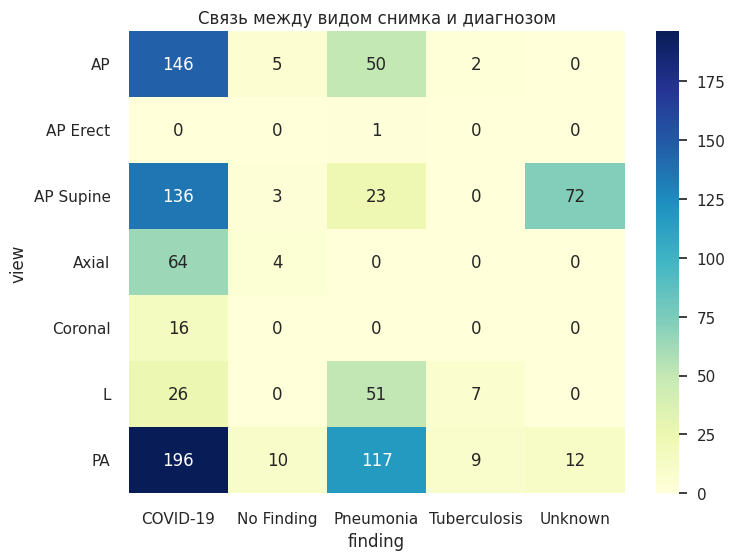

In [46]:

heatmap_data = query2.groupby(["view", "finding"]).size().unstack().fillna(0)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Связь между видом снимка и диагнозом")
plt.show()

/tmp/ipykernel_101/2854391485.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set2")


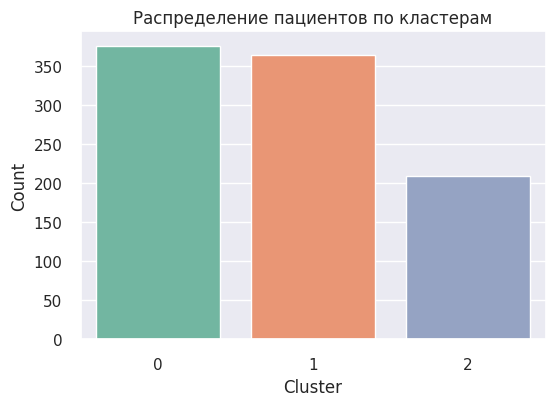

In [47]:
cluster_counts = kmeans["prediction"].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set2")
plt.title("Распределение пациентов по кластерам")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

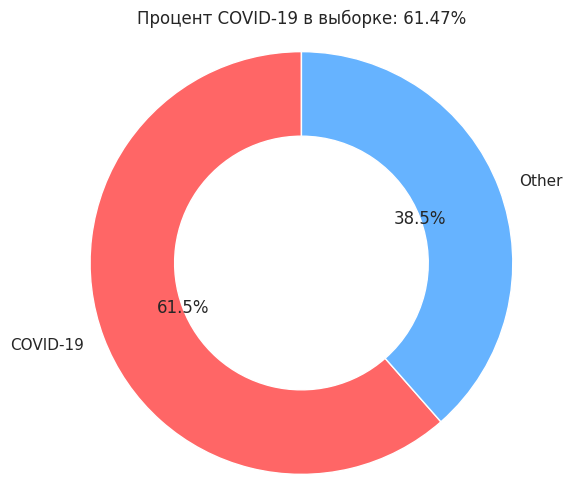

In [49]:
covid_percent = query3.iloc[0]["covid_percent"]
sizes = [covid_percent, 100 - covid_percent]
labels = ["COVID-19", "Other"]
colors = ['#ff6666', '#66b3ff']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)
)
ax.set_title(f"Процент COVID-19 в выборке: {covid_percent}%")
ax.axis('equal')  # Круглая диаграмма

plt.show()